# Lecture 6 — Classical/Frequentist Statistical Inference: II

[Open this notebook in Google Colab](https://colab.research.google.com/github/daanmeerburg/Statistics_meerburg_2026//blob/main/Lectures/Lecture_06_PDM.ipynb)


**Lecturer:** P. D. Meerburg 

*Heavily based on materials by Davide Gerosa (astroML, 2022) and collaborators. See [here](https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/README.md) for credits.*

##### Reading:

- [Ivezic textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 4. 
- [David Hogg's "Fitting A Model To Data"](https://arxiv.org/abs/1008.4686)

---

### Installing sklearn

Today we meet sklearn for the first time. This package is a true workhorse for data mining in python. If you're running code on your laptop, make sure you install this specific version:

`pip install --upgrade scikit-learn==0.23.2`

You can check what version you already have with e.g.

`pip list | grep scikit-learn`

(This is just because I checked that with this version all examples in this class work...) 

Google colab has a version of sklearn installed. The version as of writing was 1.6.1. You can check which version is installed by running:

`import sklearn`

`sklearn.__version__`


In [2]:
import sklearn
sklearn.__version__

'1.6.1'

>## Fitting A Line To Data <a class="anchor" id="one"></a>


Continuing the theme of last lecture, let's look at one of the most common tasks in statistical inference: **fitting a line to data**. We won't always fit a straight line, but they are prevalent in cosmology and particle physics since we're potentially examining data over several orders of magnitude (n fact, we are almost always trying to fit date over several orders of magnitude). Hence power-law relationships ($y\propto x^\alpha$) become linear relationships in log-log space ($\ln y \propto \alpha\ln x + \mathrm{constant}$).

Assume the noise/scatter in our measurements (the residuals) is generated by a Gaussian process, i.e.:

$$ y_i = a x_i + b + r_i $$

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the measurement uncertainty, which we take to be the same for all points. The data model includes a linear relationship with two parameters $a,b$: hence the model is written as $M(a,b)$.

Let us compute the likelihood. First, we ask ourselves what is the probability $p(y_i|x_i, M(a, b), \sigma)$; the probability of $y$, given $x$, the model and the error. It is just the normal distribution:

$$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right). $$

The likelihood for all data points is given by the product over $N$ of these terms. Given our previous definitions we can then write down the $\ln L$ as

$$ \ln L(a, b) = \mathrm{constant} - \frac{1}{2} \sum_{i=1}^N \frac{(y_i - M(x_i))^2}{\sigma^2} = \mathrm{constant} - \frac{1}{2} \chi^2.$$

This is the expression that we now ***maximize*** with respect to $a$ and $b$ to find ML estimators for those parameters. This is equivalent to ***minimizing*** the sum of the squares (the $\chi^2$) in a *least-squares method*.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
from astroML.datasets import fetch_hogg2010test

We now read in some almost linear data. For instance, these could be measures of the mass of supermassive black holes as a function of their galactic hosts (the so-called $M$-$\sigma$ relationship).

![](https://s3.amazonaws.com/aasie/images/0004-637X/764/2/184/apj459110f1_lr.jpg)


*Revisiting the Scaling Relations of Black Hole Masses and Host Galaxy Properties*, McConnell & Ma 2013 The Astrophysical Journal 764 184.

Another example is the spectrum of cosmic rays as observed by a large number of experiments. 

![Flux of cosmic rays vs flux](CosmicRaysFlux.png) 

Taken from https://pdg.lbl.gov/2022/reviews/rpp2022-rev-cosmic-rays.pdf. It shows the flux of cosmic rays as a function of energy. There are three power law's here. When assuming just a single power law, a lot of the points would become outliers.  


Our simplified data contains some **poorly modeled outliers**, which have very different uncertainties from what we assume. Say those galaxies have some features (SMBHs are active) that makes them different.


***The outlier points are the first 4 in the dataset.*** 

In [4]:
#------------------------------------------------------------
# Get data from AstroML: this includes outliers. Note that this is just test data from Hogg et al. (2010), but not real astronomical data.
data = fetch_hogg2010test()
x = data['x'] # x data
y = data['y'] # y data
dy = data['sigma_y'] # uncertainties on y data

print(x)
print(y)
print(dy)

[201. 244.  47. 287. 203.  58. 210. 202. 198. 158. 165. 201. 157. 131.
 166. 160. 186. 125. 218. 146.]
[592. 401. 583. 402. 495. 173. 479. 504. 510. 416. 393. 442. 317. 311.
 400. 337. 423. 334. 533. 344.]
[61. 25. 38. 15. 21. 15. 27. 14. 30. 16. 14. 25. 52. 16. 34. 31. 42. 26.
 16. 22.]


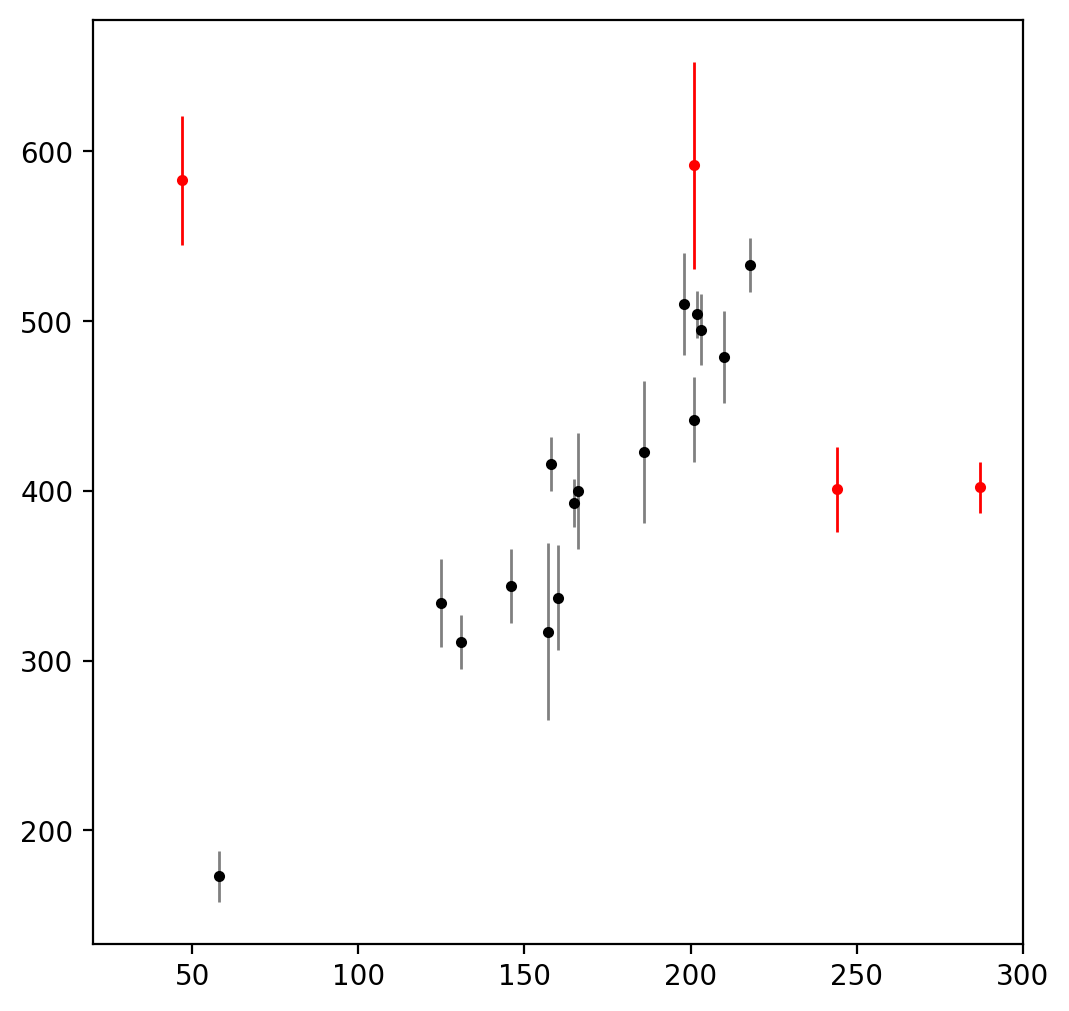

In [6]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.errorbar(x[4:], y[4:], dy[4:], # skip the first 4 points (outliers)
            fmt='.k', lw=1, ecolor='gray')

ax.errorbar(x[:4], y[:4], dy[:4], # plot the first 4 points (outliers) in red
            fmt='.', lw=1, c='red');

ax.set_xlim(20,300);


We peform a least-squares (or $\chi^2$) fit of a linear relationship (since this is Gaussian data, we know this means it's also maximizing the likelihood) for both $a$ (the slope) and $b$ (the $y$-intercept). 


In [7]:
# Define the standard squared-loss function.
# This is just another name for chi^2
def squared_loss(a, b, x, y, dy):
    y_fit = a * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1) # sum over data points, divide by uncertainties and square. The -1 means sum over the last axis.

# define a lambda function that defines the sum of squared errors.
# these lambda functions are useful!
# let's initially exclude the outliers by chopping off the first 4 points.
f_squared = lambda beta: squared_loss(beta[0], beta[1], 
                                      x=x[4:], y=y[4:], 
                                      dy=dy[4:])

#------------------------------------------------------------
# compute the maximum likelihood 
beta0 = (1, 30) # initial guess for a and b
beta_squared = optimize.fmin(f_squared, beta0) # optimize the squared loss function, this function is part of scipy

Optimization terminated successfully.
         Current function value: 18.680770
         Iterations: 53
         Function evaluations: 106


In [8]:
# print the results
beta_squared

array([ 2.23992089, 34.04772524])

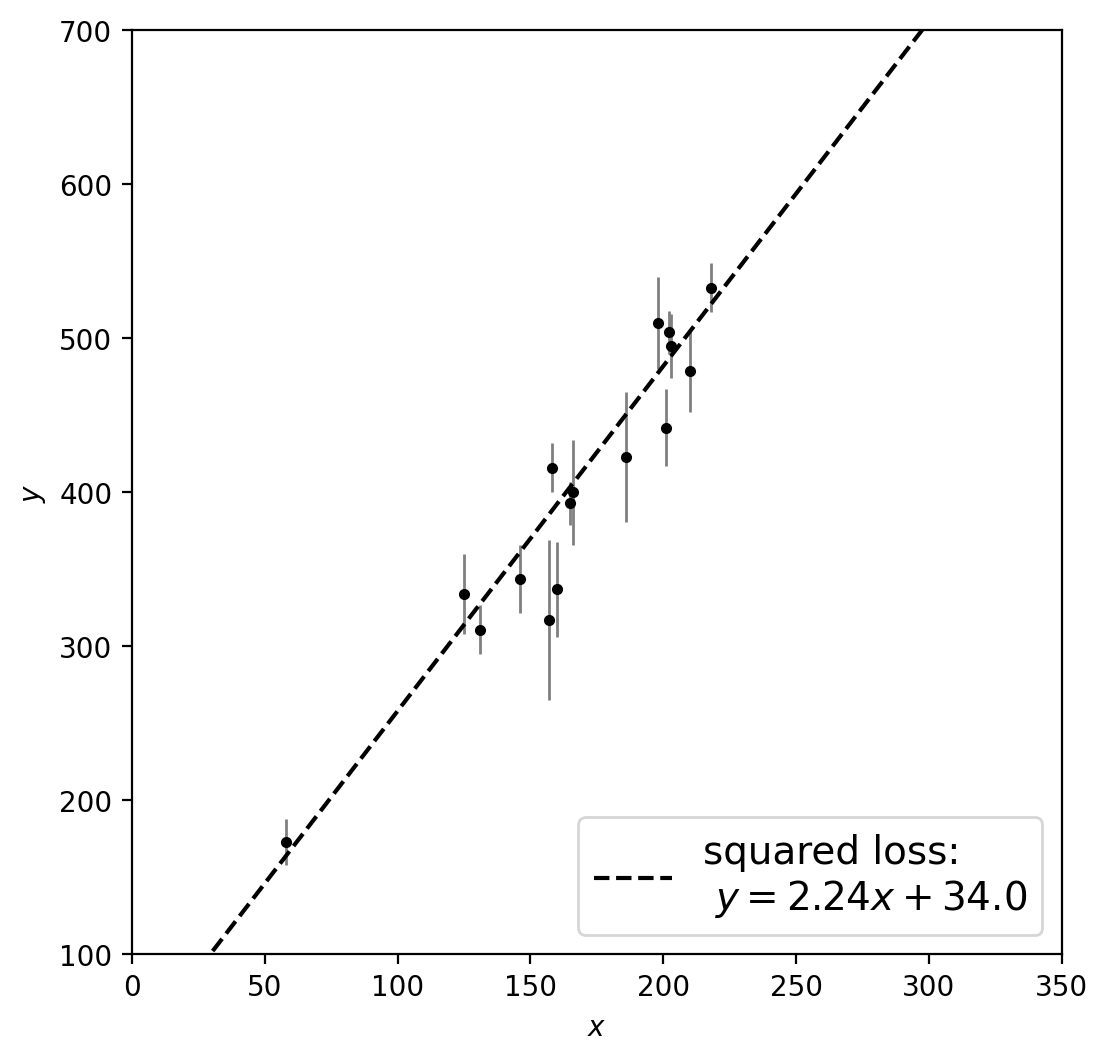

In [9]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plot the data
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')

# plot the best fit linear relationship
x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

We'll now include the outlier data points to see how they contaminate the fit, i.e. we don't need to exclude any of the points from our fit.

In [10]:
f_squared = lambda beta: squared_loss(beta[0], beta[1], 
                                      x=x, y=y, 
                                      dy=dy)

beta0 = (1, 30) # initial guess for a and b
beta_squared_outlier = optimize.fmin(f_squared, beta0)

Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 70
         Function evaluations: 133


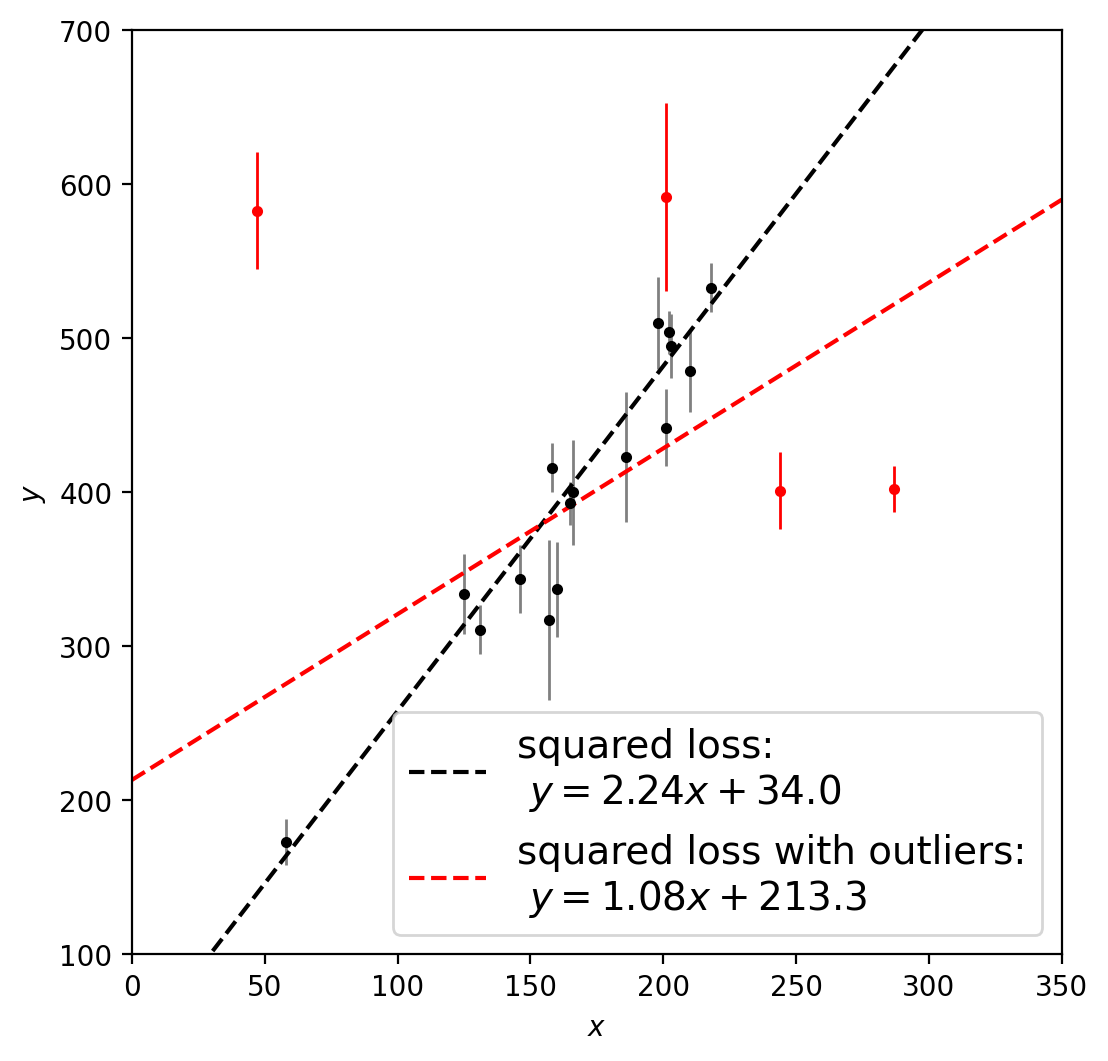

In [11]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

#Plot data
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')

ax.errorbar(x[:4], y[:4], dy[:4], 
            fmt='.', lw=1, c='red');

x_fit = np.linspace(0, 350, 10)
# plot the regular fit from before without outliers
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
# plot the fit that includes outliers
ax.plot(x_fit, beta_squared_outlier[0]*x_fit + beta_squared_outlier[1], 
        ls='--', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

That's clearly not right. 


### How do we deal with outliers: modifying the likelihood

- Summing the squares of the residuals ($\chi^2=\sum_{i=1}^N (y_i - M(x_i))^2/\sigma^2$) is sensitive to outliers.

- The $\chi^2$ is an example of an $L_2$ norm (different L here, not the likelihood), where the [$L_p$ norm](https://www.wikiwand.com/en/Lp_space) can be defined as $\sum_{i=1}^N (y_i -M(x_i))^p/\sigma^p$.

- A number of approaches exist for correcting for outliers. See in particular [David Hogg's "Fitting A Model To Data"](https://arxiv.org/abs/1008.4686) paper. 

- These include "sigma-clipping", using interquartile ranges (which you've seen in previous lectures), taking the median of solutions of subsets of the data, and least trimmed squares (which searches for the subset of points that minimizes $\sum_i^N (y_i - \theta_ix_i)^2$).


A standard approach is also changing the **likelihood** to reduce the weight of outliers. This is known as the **Huber loss function**

$$ \sum_{i=1}^N e(y_i|y),$$

where

$$
e(t) = \left\{
\begin{array}{ll}
\frac{1}{2} t^2 & \text{if } |t| \le c, \\
c|t| - \frac{1}{2} c^2 & \text{if } |t| \ge c
\end{array}
\right\}
$$

and 

$$ t = \left|\frac{y-M(x)}{\sigma}\right|.$$

This is continuous and differentiable, and transitions to an $L_1$ norm ($\sum_{i=1}^N |y_i - M(x_i)|$) for large data excursions (when you cross a threshold $c$), which downweights the outlier points.

In the image below, the blue curve is the usual $\chi^2$, $L_2$ parabola shape that we attempt to minimize, whereas the green is the alternative Huber loss function that downweights outliers ($L_1$). 

![title](https://upload.wikimedia.org/wikipedia/commons/c/cc/Huber_loss.svg)

In [16]:
# Define the log-likelihood via the Huber loss function
def huber_loss(m, b, x, y, dy, c=1): # c is the threshold parameter and is set to 1 by default
    y_fit = m * x + b # model
    t = abs((y - y_fit) / dy) # define t
    mask = t > c # define mask for large excursion points
    
    # apply masking to different points
    # note '~' means 'not'
    return np.sum(
        np.logical_not(mask) * (0.5 * t ** 2) - mask * c * (0.5 * c - t), # for small t use squared loss, for large t use linear loss
        axis=-1
    )


c=0.3

# lambda function for huber loss 
f_huber = lambda beta: huber_loss(beta[0], beta[1], 
                                  x=x, y=y, dy=dy, c=c)

#------------------------------------------------------------
# compute the maximum likelihood using the huber loss
beta0 = (1, 30)
beta_huber = optimize.fmin(f_huber, beta0)

Optimization terminated successfully.
         Current function value: 14.667158
         Iterations: 59
         Function evaluations: 114


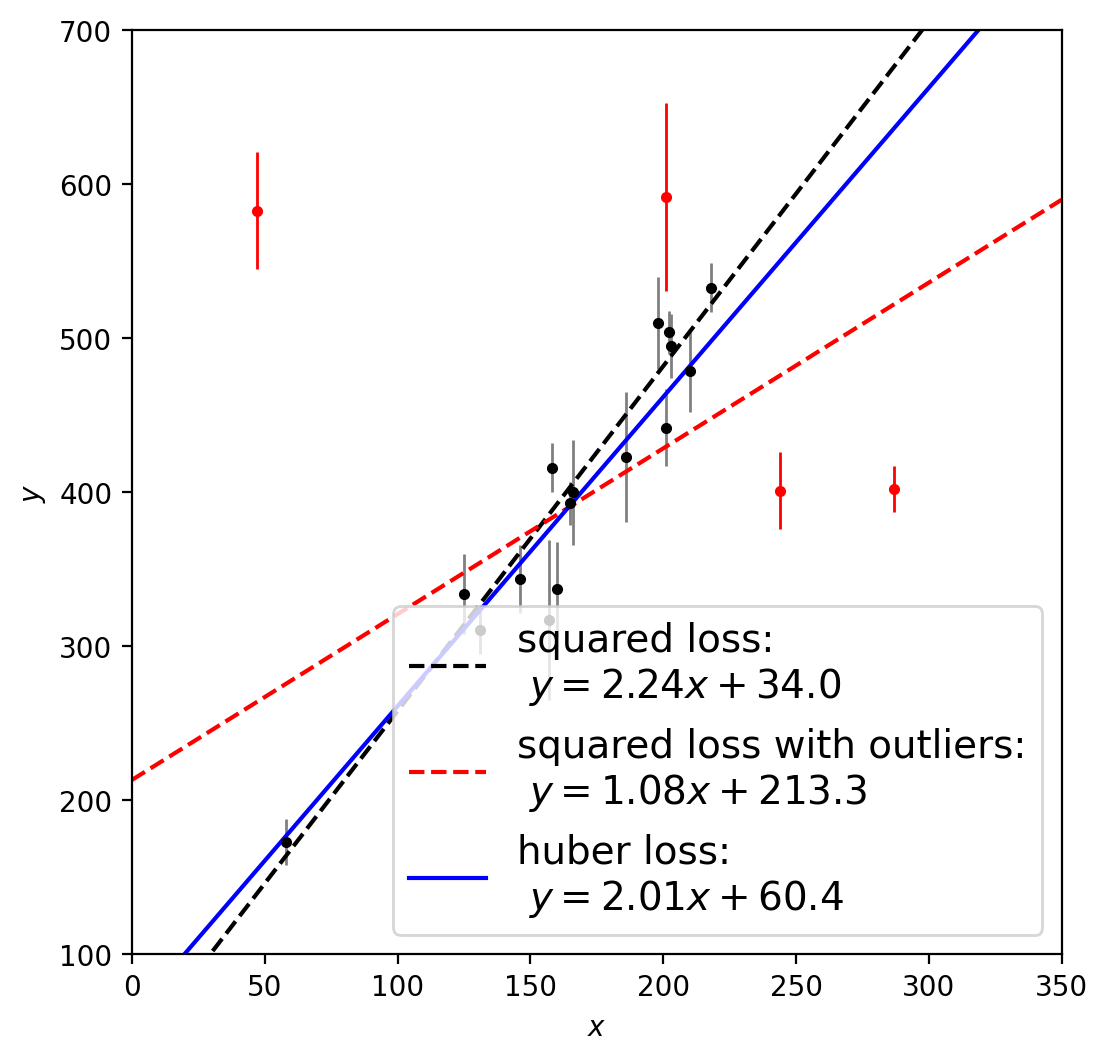

In [17]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# plot the data without outliers in gray
ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.k', lw=1, ecolor='gray')
# plot the outliers in red
ax.errorbar(x[:4], y[:4], dy[:4], 
            fmt='.', lw=1, color='red')

x_fit = np.linspace(0, 350, 10)
# plot the regular fit from before without outliers
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
# plot the fit that includes outliers
ax.plot(x_fit, beta_squared_outlier[0] * x_fit + beta_squared_outlier[1], 
        ls='--', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))
# plot the fit with the huber likelihood, downweighting outliers
ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], 
        ls='-', color='blue',
        label="huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.show()

Wow. That's much better! We're frequentists in this lecture, but note how we're still putting prior information into the analysis. We **know** that the error bar on those red points are wrong (they're too small!) so we downeight them accordingly.

Try making $c$ larger (say 5 or 6)...

>## Goodness Of Fit & Model Comparison <a class="anchor" id="two"></a>

The MLE approach tells us what the "best" model parameters are, but not how good the fit actually is. If the model is wrong, "best" might not be particularly revealing! Remember this acronym from the dawn of the computer age: ***GIGO = Garbage In, Garbage Out***. 

If we have a crappy model then we shouldn't expect a good fit to the data. For example, if you have $N$ points drawn from a linear distribution, you can always fit the data perfectly with an $N-1$ order polynomial. But that won't help you predict future measurements.

We can describe the **goodness of fit** in words as simply the followng

> *The goodness of fit tells us whether or not it is likely to have obtained the maximum (log-)likelihood $\ln L^0$ by randomly drawing from the data.* 

Using the best-fit parameters of a model, the maximum likelihood value $L^0$ should not be an unlikely occurence. If it is, then our model is not describing the data well. Thus we need to know the *distribution* of $\ln L$ and not just its maximum. For the Gaussian case we have just described, we do a standard transform of variables and compute the so-called $z$ score for each data point (basically the number of standard deviations away from the mean that this point is), writing 

$$z_i = (x_i-\mu)/\sigma,$$ 

then

$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N z_i^2 = {\rm constant} - \frac{1}{2}\chi^2.$$

Here, $\chi^2$ is the thing whose distribution we discussed in early lectures.

**So for Gaussian uncertainties, $\ln L$ is distributed as $\chi^2$.**  

Let's rememember how the $\chi^2$ distribution looks like. We've seen this already:

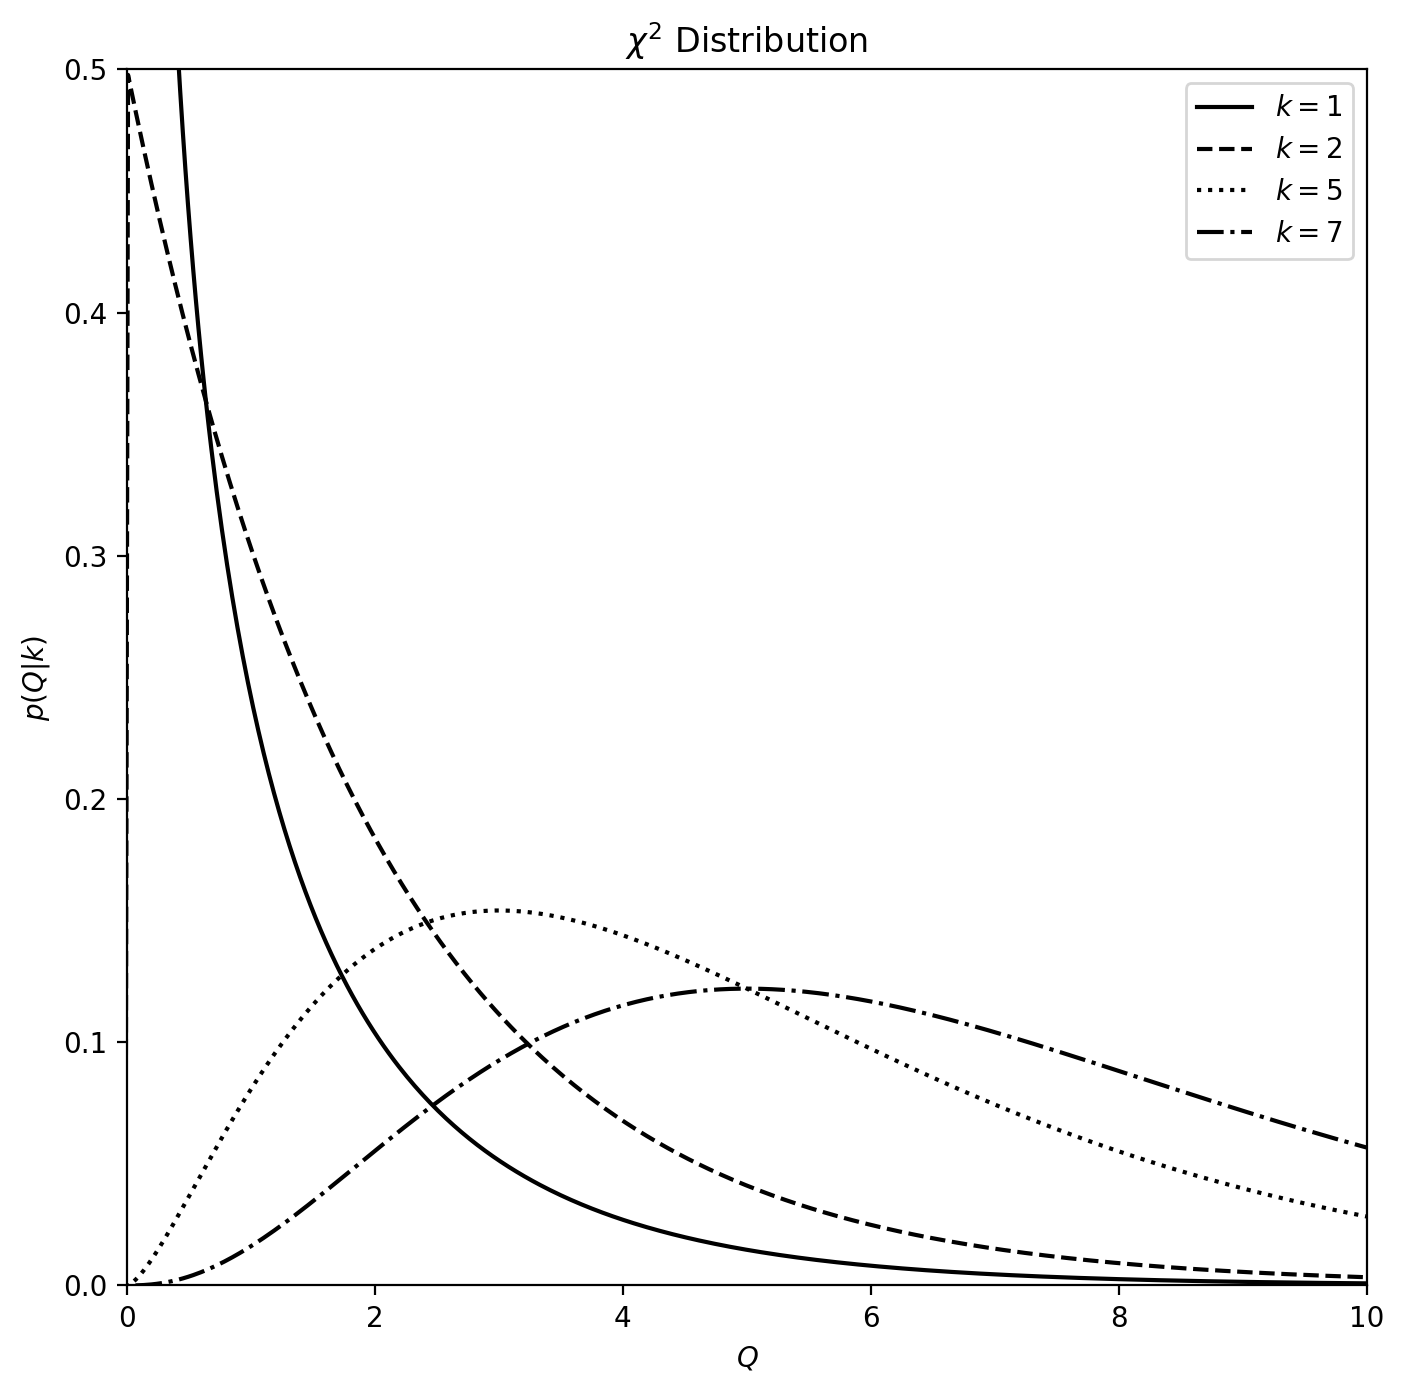

In [18]:
r"""
Example of a chi-squared distribution
---------------------------------------
Figure 3.14.
This shows an example of a :math:`\chi^2` distribution with various parameters.
We'll generate the distribution using::
    dist = scipy.stats.chi2(...)
Where ... should be filled in with the desired distribution parameters
Once we have defined the distribution parameters in this way, these
distribution objects have many useful methods; for example:
* ``dist.pmf(x)`` computes the Probability Mass Function at values ``x``
  in the case of discrete distributions
* ``dist.pdf(x)`` computes the Probability Density Function at values ``x``
  in the case of continuous distributions
* ``dist.rvs(N)`` computes ``N`` random variables distributed according
  to the given distribution
Many further options exist; refer to the documentation of ``scipy.stats``
for more details.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import chi2
from matplotlib import pyplot as plt


#------------------------------------------------------------
# Define the distribution parameters to be plotted
k_values = [1, 2, 5, 7]
linestyles = ['-', '--', ':', '-.']
mu = 0
xx = np.linspace(-1, 20, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(8,8))
fig.subplots_adjust(bottom=0.12)

for k, ls in zip(k_values, linestyles):
    dist = chi2(k, mu)

    plt.plot(xx, dist.pdf(xx), ls=ls, c='black',
             label=r'$k=%i$' % k)

plt.xlim(0, 10)
plt.ylim(0, 0.5)

plt.xlabel('$Q$')
plt.ylabel(r'$p(Q|k)$')
plt.title(r'$\chi^2\ \mathrm{Distribution}$')

plt.legend()
plt.show()

***The mean of the $\chi^2$ distribution is $N-k$ and its standard deviation is $\sqrt{2(N-k)}$.***

We define the $\chi^2$ per degree of freedom, $\chi^2_\mathrm{dof}$, as

$$\chi^2_\mathrm{dof} = \frac{1}{N-k}\sum_{i=1}^N z^2_i.$$

where $k$ is the number of model parameters determined from the data.

- For a good fit, we would expect that $\chi^2_\mathrm{dof}\approx 1$. 
- If $\chi^2_\mathrm{dof}$ is significantly larger than 1, or $(\chi^2_\mathrm{dof}-1)>> \sqrt{2/(N-k)}$, then it is likely that we are not using the correct model.
- If data uncertainties are **(over)under-estimated** then this can lead to improbably **(low)high $\chi^2_\mathrm{dof}$**, as seen below.  

![Ivezic, Figure 4.1](http://www.astroml.org/_images/fig_chi2_eval_1.png)

Read through and execute the following cell to compute $\chi^2_\mathrm{dof}-1$ for the line fitted without outliers and fitted with outliers. These will be compared to the standard deviation of the $\chi^2_\mathrm{dof}-1$ distributions.

In [19]:
# number of data points *without* outliers
N = x[4:].shape[0]
# number of data points *with* outliers
N_outlier = x.shape[0]
# number of model parameters (a,b)
k = 2 

print(x[4:].shape)

# chi2 per dof *without* outliers
chi2 = squared_loss(beta_squared[0], 
                    beta_squared[1], 
                    x=x[4:], y=y[4:], dy=dy[4:])
chi2dof = chi2 / (N-k)

# chi2 per dof *with* outliers
chi2_outlier = squared_loss(beta_squared_outlier[0], 
                            beta_squared_outlier[1], 
                            x=x, y=y, dy=dy)
chi2dof_outlier = chi2_outlier / (N_outlier - k)

# without outliers
found =  chi2dof-1
expected = np.sqrt(2/(N-k))

print("Without outlier. chi2dof-1:", found, "std:", expected, "Nsigma:", found/expected)

# with outliers
found =  chi2dof_outlier-1
expected = np.sqrt(2/(N_outlier-k))

print("With outlier. chi2dof-1:", found, "std:", expected, "Nsigma:", found/expected)


(16,)
Without outlier. chi2dof-1: 0.33434070794594706 std: 0.3779644730092272 Nsigma: 0.8845823663902529
With outlier. chi2dof-1: 15.109095710111468 std: 0.3333333333333333 Nsigma: 45.327287130334405


We divided the measured value by the expected one to get the sigma deviation from the desired value of zero. The lower the better. These results show that the outliers are pushing towards a poor fit of the data. Effectively, most data points are now many sigma's away from the curve, summing to a very poor $\chi^2$. 

### Model Comparison

**The distribution of $\ln L$ can only be related to the $\chi^2$ distribution whenever the likelihood is Gaussian**. For non-Gaussian likelihoods we can still rank different models in terms of their respectively computed maximum likelihood values, $L^0$. This is only really fair if the models have the same number of parameters.

Let's do that for the data above that contains outliers, both for a model based on the naive squared loss function ($\chi^2$), and a Huber loss function model.

In [20]:
# compute a quantity related to lnL0 for the 
# squared loss function
lnL_sq = - squared_loss(beta_squared_outlier[0], 
                        beta_squared_outlier[1], 
                        x=x, y=y, dy=dy)

# compute a quantity related to lnL0 for the 
# Huber loss function
lnL_huber = - huber_loss(beta_huber[0], 
                         beta_huber[1], 
                         x=x, y=y, dy=dy)

print("Maximum log likelihood for squared loss = %.1f" % lnL_sq)
print("Maximum log likelihood for Huber loss = %.1f" % lnL_huber)

Maximum log likelihood for squared loss = -290.0
Maximum log likelihood for Huber loss = -43.6


Unsurprisingly, the Huber loss function model is much much better (that's in log!).

We need a modified approach whenever the models we're comparing have different numbers of parameters. Such an approach should account for **model complexity** and **effectively penalize models with additional parameters that are not constrained by the data**. This is often called an ***Occam penalty***, because we're trying to incorporate [Occam's Razor](https://www.wikiwand.com/en/Occam%27s_razor#:~:text=Occam's%20razor%2C%20Ockham's%20razor%2C%20Ocham's,is%20usually%20the%20right%20one.).

> *All else being equal (i.e., each model fits the data equally well), the less complex model is favored.*


We'll meet this in extensive detail later, especially in a Bayesian context. But a popular general-purpose tool for model comparison is the **Akaike Information Criterion** (AIC):

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

where $k$ is the number of model parameters and $N$ is the number of data points. See e.g. https://arxiv.org/pdf/1308.3704 for an application of this criteria in my own work (I did not have the third term). 

- For a Gaussian distribution, the first term is equal to $\chi^2$.
- **The model with lowest AIC is the most favored.**
- If all models are equally successful at fitting the data (equal $L^0$ values) then the second and third terms penalize model complexity such that the model with fewest free parameters wins. 

The AIC is a good quick and dirty estimate for the goodness of fit based on some asymptotic approximations (cf.  [Wasserman's textbook](https://link.springer.com/book/10.1007/978-0-387-21736-9) if you're interested). The preferred approach is **cross validation**. Cross validation is at the heart of all deep-learning workflows that you might encounter in the MSc on Deep Learning.



>## Confidence Estimating: Bootstrap & Jackknife <a class="anchor" id="three"></a>

Most ways of computing confidence limits and uncertainties on measured model parameters assume that the distribution is Gaussian and our samples are large. But even if that is not the case, we can still compute good confidence intervals (e.g., $a<x<b$ with 95\% confidence) using ***resampling*** strategies.

Boostrap and jackknife are the two modern approaches to the problem, which have been made possible by the available computing power. 

Remember that we have a data set $\{x_i\}$ from which we have estimated the distribution as $f(x)$ for a true distribution $h(x)$.  

### Bootstrap Method

In bootstrapping, we map the uncertainty of model parameters by re-sampling from our data (with replacement) $B$ times. This is relatively new (Efron, 1979) and was named in inspiration of "*pulling oneself up by one's bootstraps*".

When sampling from observed data of length $N$ with replacement, there are $N!$ distinct combinations of new observed datasets, and there is only a $N!/N^N$ probability of getting back the original dataset (even for $N=10$ this is only $0.00036$). 

With $B$ new bootstrap datasets, we compute our statistics on each to obtain $B$ measures of our parameters. So, if we have $i=1,\dots,N$ data points in $\{x_i\}$, we draw $N$ of them to make a new sample, where some values of $\{x_i\}$ will be used more than once (and this is ok).

**EXAMPLE**
- We have an original dataset of $1000$ points drawn from a Gaussian distribution. 
- We can only measure the standard deviation of the distribution once with this dataset. 
- Our previous strategies showed that we can use a *Fisher estimate* or an *analytic estimate* of the sample standard deviation uncertainty. 
- Instead, we use the bootstrap method to resample the data $10,000$ times, and compute the standard deviation and $\sigma_G$ on each new dataset. 
- This will map out the uncertainty distribution of those statistics, allowing us to quote confidence limits in our actual measured value. 


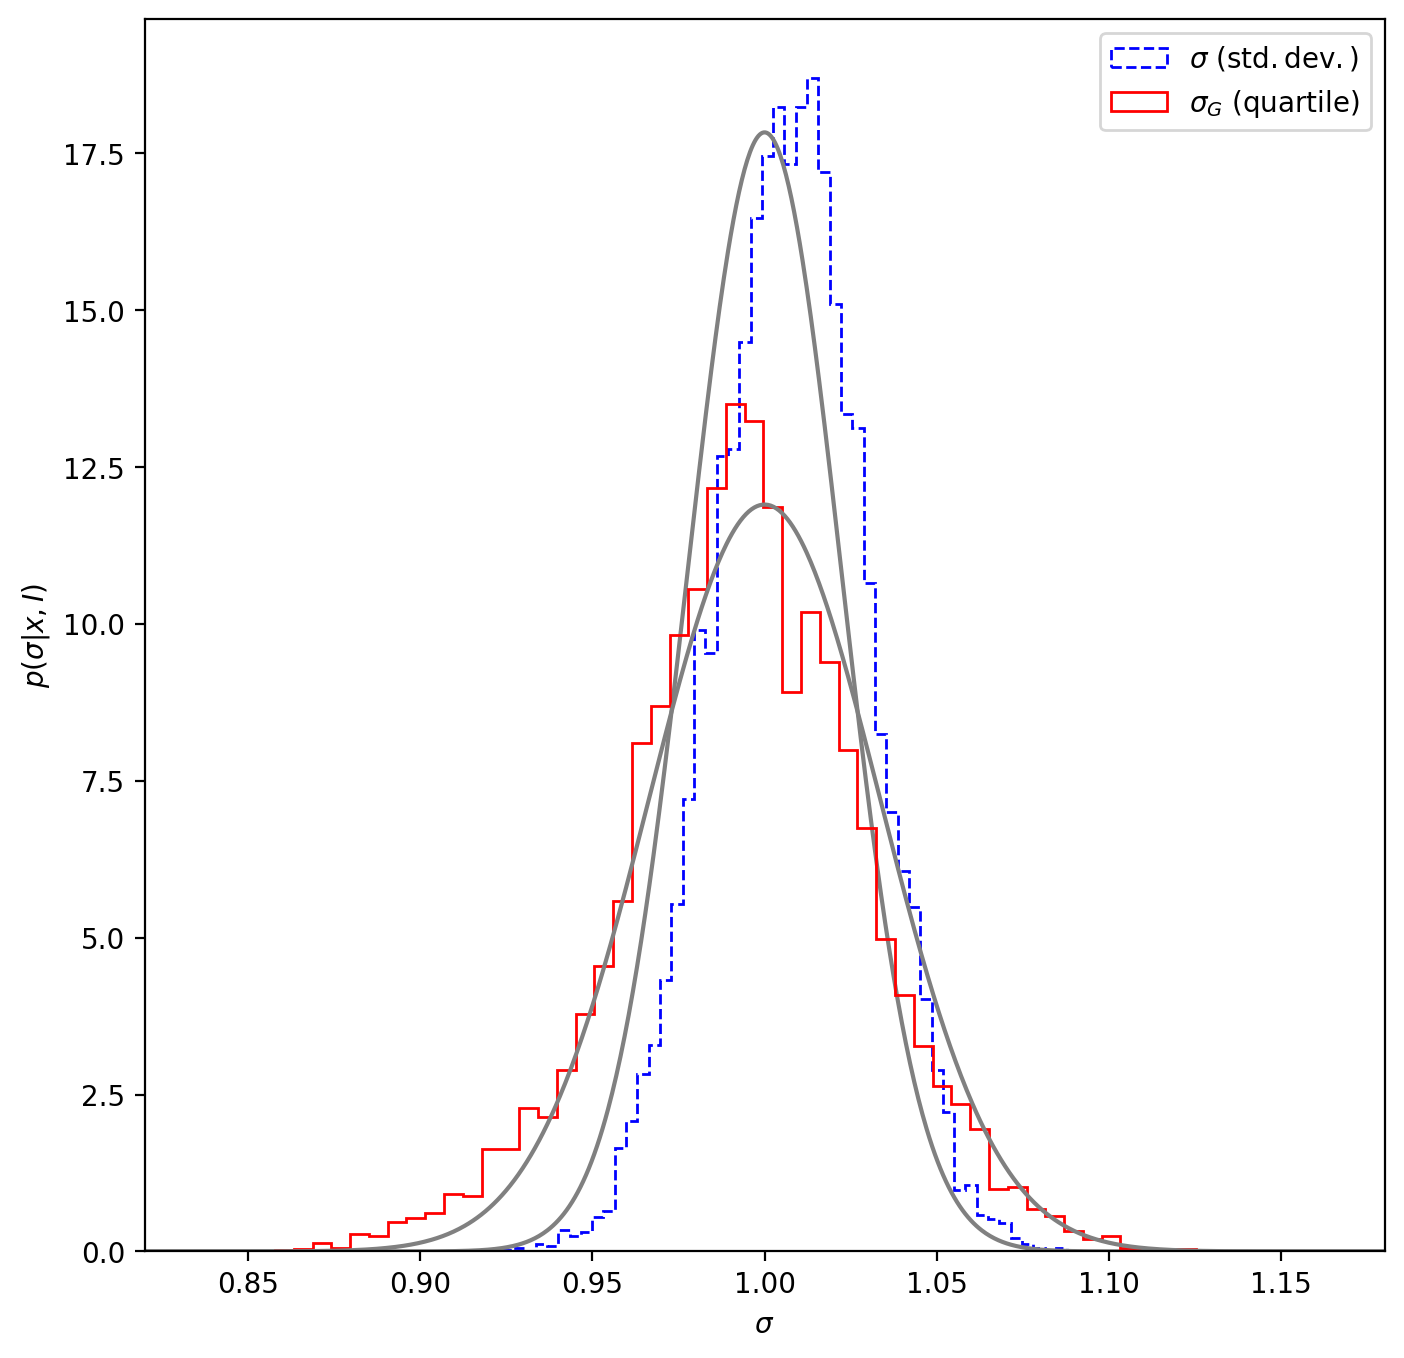

In [21]:
# Ivezic v2, Figure 4.3, modified slightly by GTR and SRT
# %load ../code/fig_bootstrap_gaussian.py
# Author: Jake VanderPlas
# License: BSD

from astroML.resample import bootstrap
from astroML.stats import sigmaG

m = 1000  # number of points
n = 10000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(11)
data = norm(0, 1).rvs(m) # generate m random values from a normal distribution with mean 0 and stddev 1

#------------------------------------------------------------
# Compute bootstrap resamplings of data
mu1_bootstrap = bootstrap(data, n, np.std, 
                          kwargs=dict(axis=1, ddof=1)) # ddof=1 means use sample standard deviation (not population standard deviation)
mu2_bootstrap = bootstrap(data, n, sigmaG, 
                          kwargs=dict(axis=1)) # sigmaG is the robust standard deviation estimator based on the interquartile range

#------------------------------------------------------------
# Compute the theoretical expectations for the two distributions
xgrid = np.linspace(0.8, 1.2, 1000)

sigma1 = 1. / np.sqrt(2 * (m - 1)) # standard error of the standard deviation estimator
pdf1 = norm(1, sigma1).pdf(xgrid) # probability density function for the standard deviation estimator

sigma2 = 1.06 / np.sqrt(m)  # standard error of the sigmaG estimator
pdf2 = norm(1, sigma2).pdf(xgrid) # probability density function for the sigmaG estimator

#------------------------------------------------------------
# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))

ax.hist(mu1_bootstrap, bins=50, density=True, 
        histtype='step', color='blue', ls='dashed', 
        label=r'$\sigma\ {\rm (std. dev.)}$')
ax.plot(xgrid, pdf1, color='gray')

ax.hist(mu2_bootstrap, bins=50, density=True, 
        histtype='step', color='red', 
        label=r'$\sigma_G\ {\rm (quartile)}$')
ax.plot(xgrid, pdf2, color='gray')

ax.set_xlim(0.82, 1.18)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')
ax.legend()

plt.show()

The above shows the bootstrap uncertainty estimates for the sample standard deviation $\sigma$ (blue dashed) and $\sigma_G$ (red solid). The thin grey lines show Gaussians with the theoretical widths determined as $\sigma_s = s\, / \sqrt{2(N - 1)}$ and $\sigma_{\sigma_G} = 1.06\, s\, / \sqrt{N}$. (you can play round with the number of bootstraps and number of points to check if the distributions get closer to the theoretocal prediction). 

### Jackknife Method 

This is similar to bootsrapping except that we don't use a sample size of $N$. Rather, ***we leave off one or more of the observations*** from $\{x_i\}$. As with bootstrap, we do this multiple times, generating samples from which we can determine our uncertainties.

- If we leave out just one datapoint each time, we can make $N$ such datasets that each contain $(N-1)$ data points.
- We compute our statistic or find our model parameters in each of these jackknife datasets.

For jackknifing by leaving out one datapoint, the bias-corrected jackknife estimate of a statistic $\alpha$ is

$$ \alpha^J = \alpha_N + \Delta\alpha,$$

where $\alpha_N$ is the statistic computed on the original dataset, and 

$$ \Delta\alpha = (N-1)\left( \alpha_N - \frac{1}{N}\sum_{i=1}^N \alpha^*_i \right),$$

where $\{\alpha_i^*\}$ are the statistics computed on the $N$ jackknife datasets. 

For asymptoticically normal estimators, the standard error on $\alpha^J$ is

$$ \sigma_\alpha = \sqrt{\frac{1}{N(N-1)}\sum_{i=1}^N [N\alpha_N - \alpha^J - (N-1)\alpha^*_i]^2}.$$

Confidence limits on $\alpha$ can be computed using the Student's $t$ distribution with $t=(\alpha-\alpha^J)/\sigma_\alpha$ and $(N-1)$ degrees of freedom (see Supplement for derivation). 

**NOTES**
- The jackknife standard error is more reliable than the bias correction.
- Standard jackknife (removing one point) does well for statistics like the mean and standard deviation, but is poor with rank-based statistics (e.g., median, quantiles, $\sigma_G$). 
- This is because (as we've seen) rank-based statistics are not very sensitive to adding/removing single data points. So jackknifing can give many identical values of the statistic!
- This can be resolved by modifying the jackknife to leave off more than one datapoint.


**EXAMPLE**
- We compute jackknife uncertainty estimates for the width of a Gaussian distribution, using the same data as in the bootstrap example.
- The $N$ jackknife estimates of $\sigma$ and $\sigma_G$ will be shown, but the `astroML` jackknife method automatically incorporates the bias correction mentioned above.


1.0015366861435233 0.02228013942047898
0.597747861971019 0.031353107946452324
mu_1 mean: 1.00 +- 0.02
mu_2 mean: 0.60 +- 0.03


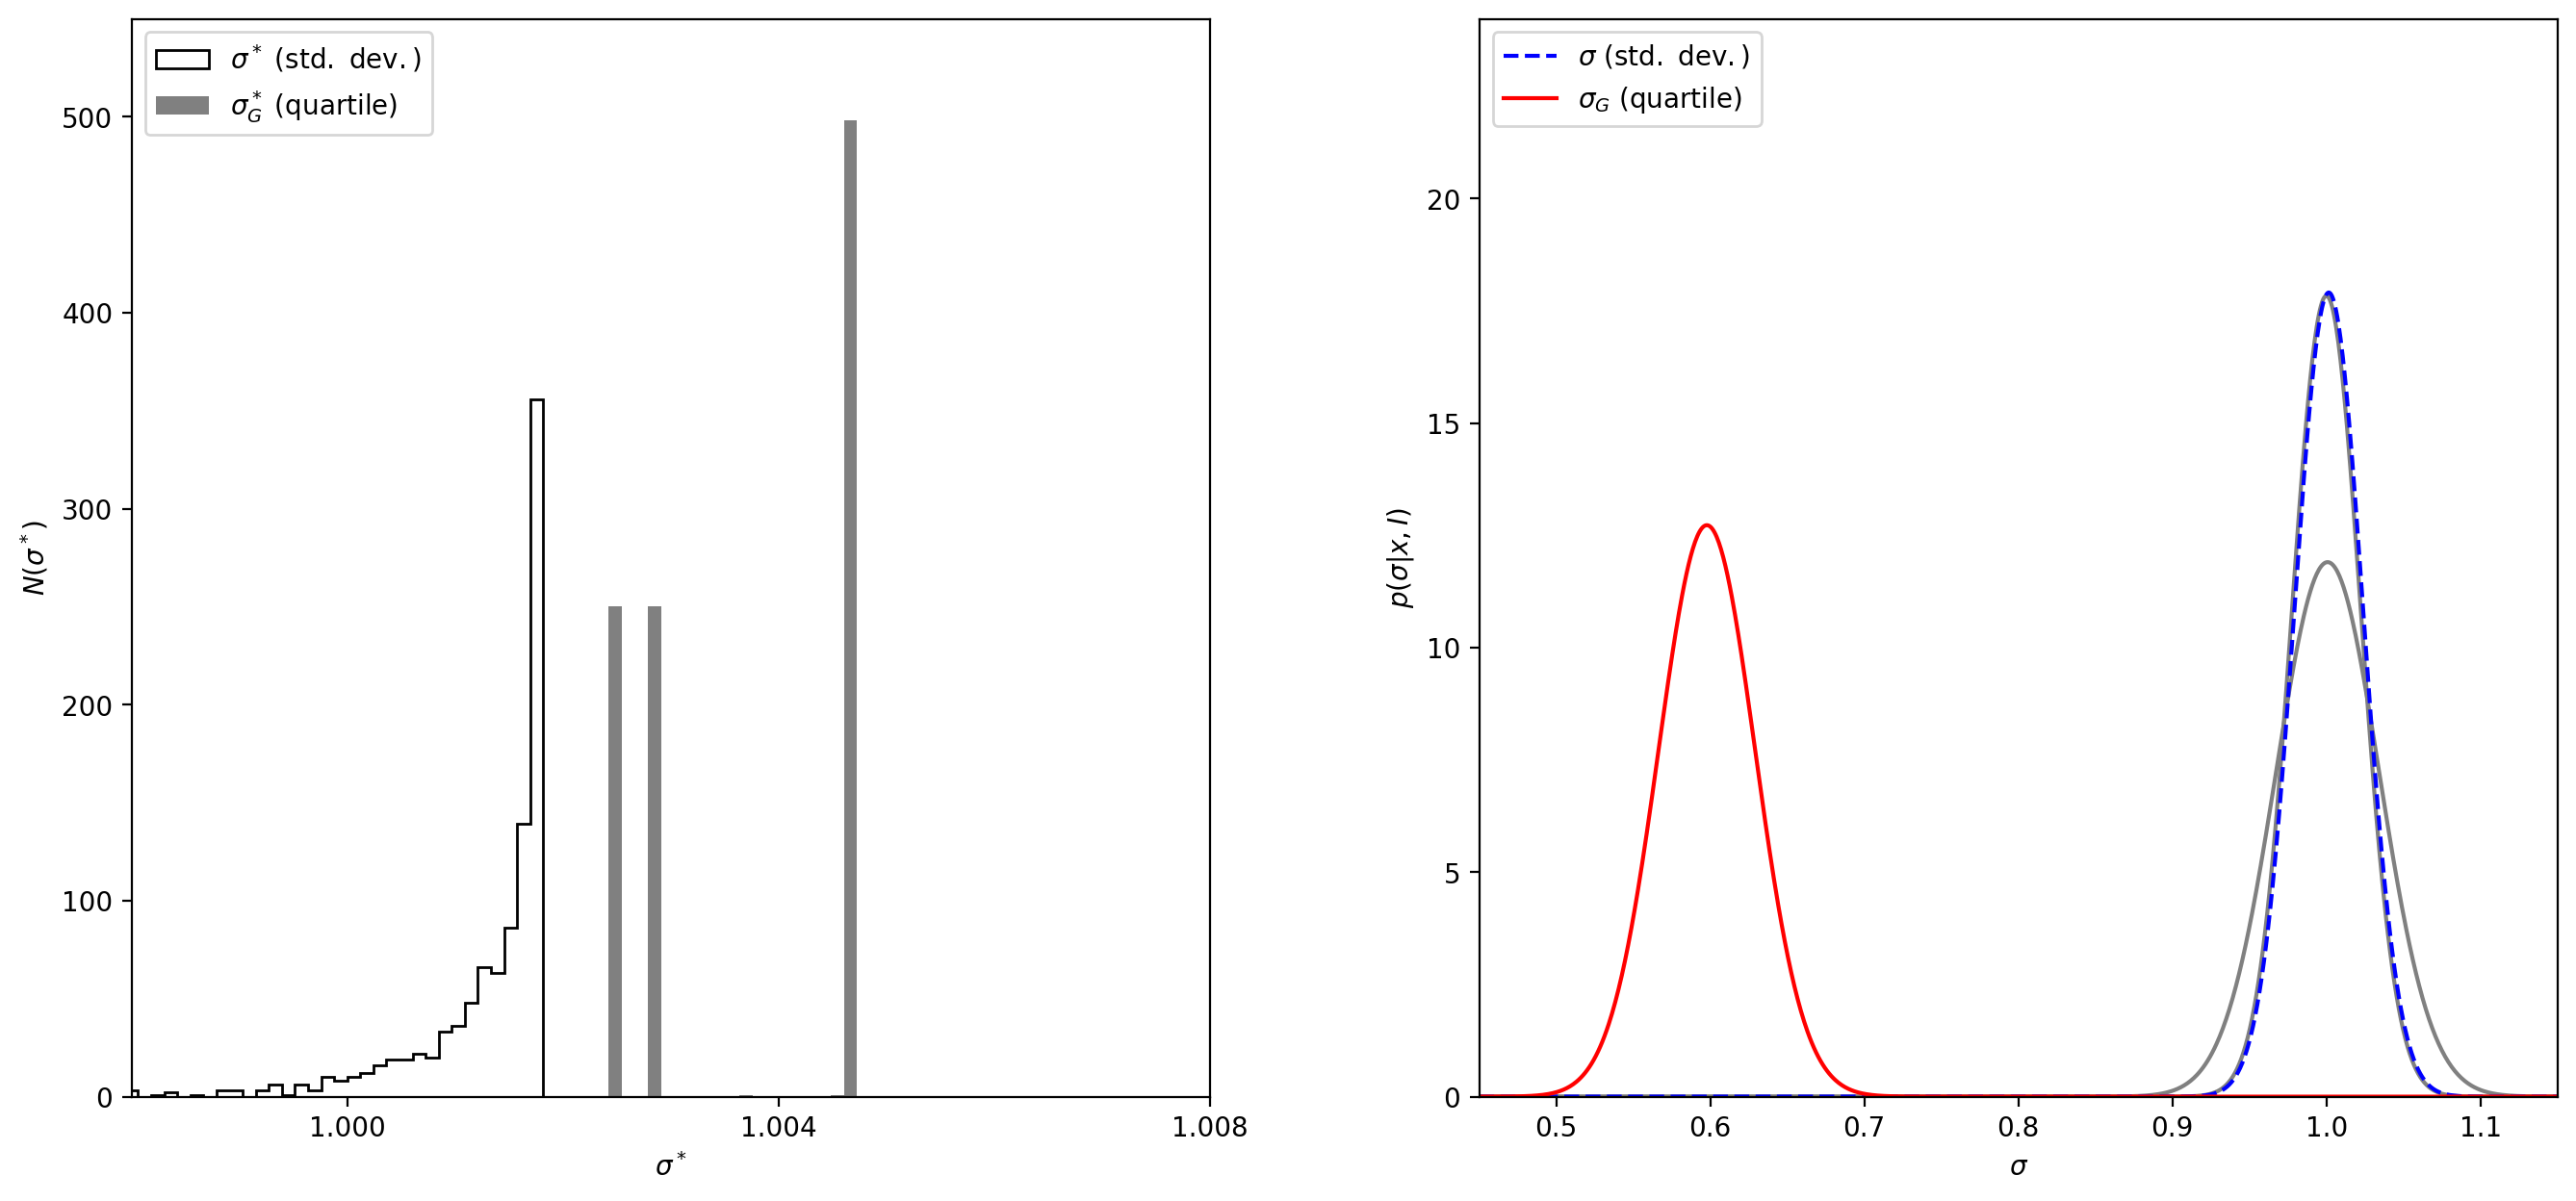

In [24]:
# Ivezic v2, Figure 4.4, modified slightly by SRT
# %load ./code/fig_jackknife_gaussian.py
# Author: Jake VanderPlas
# License: BSD

from astroML.resample import jackknife
from astroML.stats import sigmaG

m = 1000  # number of points
n = 1000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(123)
data = norm(0, 1).rvs(m)

# mu1 is the mean of the standard-deviation-based width
mu1, sigma_mu1, mu1_raw = jackknife(data, np.std, 
                                    kwargs=dict(axis=1, ddof=1),
                                    return_raw_distribution=True)

pdf1_theory = norm(1, 1. / np.sqrt(2 * (m - 1))) # theoretical distribution
pdf1_jackknife = norm(mu1, sigma_mu1) # bias-corrected jackknife estimate
print(mu1, sigma_mu1)

# mu2 is the mean of the interquartile-based width
#  WARNING: do not use the following in practice.  This example
#           shows that jackknife fails for rank-based statistics.
mu2, sigma_mu2, mu2_raw = jackknife(data, sigmaG,
                                    kwargs=dict(axis=1),
                                    return_raw_distribution=True)
pdf2_theory = norm(data.std(), 1.06 / np.sqrt(m)) # theoretical distribution
pdf2_jackknife = norm(mu2, sigma_mu2)
print(mu2, sigma_mu2)

#------------------------------------------------------------
# plot the results
print("mu_1 mean: %.2f +- %.2f" % (mu1, sigma_mu1))
print("mu_2 mean: %.2f +- %.2f" % (mu2, sigma_mu2))

fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(left=0.11, right=0.95, bottom=0.2, top=0.9,
                    wspace=0.25)

# plot all jacnknife results on histogram
ax = fig.add_subplot(121)
ax.hist(mu1_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma^*\ {\rm (std.\ dev.)}$',
        histtype='stepfilled', fc='white', 
        ec='black', density=False)
ax.hist(mu2_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma_G^*\ {\rm (quartile)}$',
        histtype='stepfilled', fc='gray', 
        density=False)
ax.legend(loc='upper left', handlelength=2)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.004))
ax.set_xlabel(r'$\sigma^*$')
ax.set_ylabel(r'$N(\sigma^*)$')
ax.set_xlim(0.998, 1.008)
ax.set_ylim(0, 550)

# plot the bias-corrected jackknife estimates
ax = fig.add_subplot(122)
x = np.linspace(0.45, 1.15, 1000)
ax.plot(x, pdf1_jackknife.pdf(x),
        color='blue', ls='dashed', 
        label=r'$\sigma\ {\rm (std.\ dev.)}$',
        zorder=2)
ax.plot(x, pdf1_theory.pdf(x), 
        color='gray', zorder=1)
ax.plot(x, pdf2_jackknife.pdf(x),
        color='red', 
        label=r'$\sigma_G\ {\rm (quartile)}$', 
        zorder=2)
ax.plot(x, pdf2_theory.pdf(x), 
        color='gray', zorder=1)
plt.legend(loc='upper left', handlelength=2)


ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')
ax.set_xlim(0.45, 1.15)
ax.set_ylim(0, 24)

plt.show()

The **left panel** shows a histogram over all $N$ jackknife datasets of the widths determined using the sample standard deviation, and using $\sigma_G$ (from the interquartile range). This is referred to as raw_mu in the code. 

The **right panel** shows the bias-corrected jackknife estimates (see above) for the two methods. The gray lines show the theoretical results as before in the bootstrap example. The jackknife result for $\sigma$ matches the theoretical result almost exactly, but note the failure of the jackknife to correctly estimate $\sigma_G$. *Jackknifing does poorly for rank-based statistics!*

Note also that the raw histograms of the jackknive corrected std's has few points below the true std (1) and lots more points high. This is because for any given distribution, if you take out a random point, it tends to be close to the peak of the distribution (so the mean of a Gaussian). [Ok I need to explain this better]

### When to bootstrap or jackknife?

- Jackknife estimates are usually easier to calculate, easier to apply for complex sampling schemes, and automtically remove bias.
- Bootstrap is better for computing confidence intervals because it maps out the full distribution of the statistic instead of assuming asymptotic normality.
- Bootstrap is random resampling so gives different results each time. Whereas jackknifing gives repeatable results.

It is generally a good idea to use both methods and compare the results. Use either/both with caution with $N$ is small!

But in general, **cross validation** is the way to go. We'll see this carefully in a few lectures.

>## Assignment: Gaussian Mixtures

Many problems in particle physics and cosmology give rise to data with multiple modes. This is typically because different processes physical processes contribute to the observed dataset. 

In davide's version, the example of the formation channel for binary black holes is considered. This is perfectly good example, and I encourage the students to explore this example and the solution below. Instead we will look at a common fitting problem in collider physics. We will come back to this in lecture 9, when discussing Bayesian inference. It turns out the following is pretty challanging problem. 







### Class labels or "responsibilities"

Class labels are a very interesting by products of a mixture analysis.

What is the probability that a given gravitational-wave event comes from a given channel? This is called "responsiblity" (i.e. which mode is most likely to be responsible for that piece of data). 

$p(j|x_i) = \frac{a_j \mathcal{N(\mu_j,\sigma_j)}}{\sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j)}$


#### At home: derive this using Bayes' rule

## The data: dimuon invariant mass events from the LHC

At the Large Hadron Collider (LHC), protons are collided at extremely high energies. In each collision, many particles can be produced. Occasionally, a collision produces **two muons**.

As you are prpbbaly aware, a **muon** is a heavier cousin of the electron. It is electrically charged and travels long distances through the detector, which makes it one of the cleanest particles to measure experimentally.

Each time the detector records **two muons in the same collision event**, the experiment stores information about their energies and momenta.

---

## Invariant mass

From the measured energies and momenta of the two muons, we can compute a single quantity called the **invariant mass** of the muon pair, denoted by

$$
m_{\mu\mu}.
$$

The invariant mass has an important physical interpretation:

> If two particles were produced by the decay of a short-lived intermediate particle,  
> then the invariant mass of the decay products is equal to the mass of that parent particle.

This means that even if the parent particle exists only briefly and cannot be observed directly, its mass leaves a clear imprint in the distribution of $m_{\mu\mu}$.

---

## What does the dataset contain?

The dataset used in this lecture consists of many such collision events:

- each row corresponds to **one proton--proton collision**,
- each collision produced **two muons**,
- for each event, we compute the invariant mass $m_{\mu\mu}$.

From a statistical point of view, the dataset is simply a list of numbers:

$$
\{ m_{\mu\mu}^{(1)}, m_{\mu\mu}^{(2)}, \dots, m_{\mu\mu}^{(N)} \}.
$$

There are no labels and no classifications --- just one measured number per event.

---



In [28]:

#now lets us load the data from CMS

import pandas as pd
url = 'https://opendata.cern.ch/record/700/files/MuRun2010B.csv'
data = pd.read_csv(url)
masses = data['M']  # invariant mass


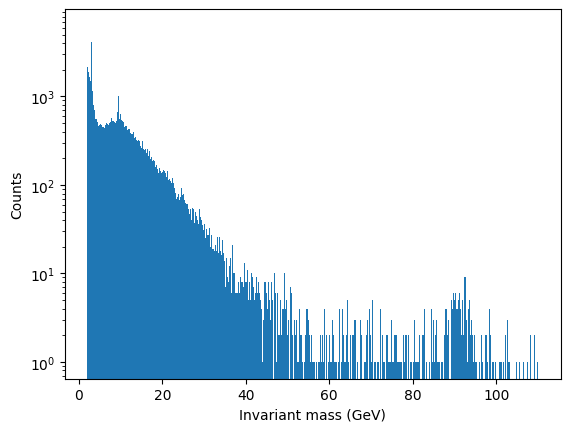

In [29]:
# Next we plot the data:

import matplotlib.pyplot as plt
plt.hist(masses, bins=1000, range=(2, 110))
plt.yscale('log')
plt.xlabel('Invariant mass (GeV)')
plt.ylabel('Counts')
plt.show()


## Why does the histogram show several peaks?

If we plot a histogram of the invariant mass values, we observe:

- a smooth background from random processes,
- several **narrow peaks** at specific mass values.

Each peak corresponds to a real physical particle that:
- was produced in the collision,
- lived for a very short time,
- decayed into two muons.

Examples include:
- the $J/\psi$ particle,
- its excited state $\psi(2S)$,
- heavier bound states of bottom quarks, denoted by $\Upsilon$.

These particles all decay into muon pairs, but they have **different masses**, which leads to multiple peaks in the distribution.

---

## Statistical interpretation

From a statistical perspective:

- each event belongs to one of several **underlying populations**,
- these populations are not directly observed,
- each population produces invariant masses clustered around a characteristic value.

Because of detector resolution and measurement noise, each cluster is well approximated by a **Gaussian distribution**.

The observed distribution can therefore be modeled as:

- a mixture of several Gaussian components,
- plus a smooth background contribution.

This is an example of a **mixture model**, where the population membership of each data point is unknown.

---

## Connection to this lecture

In this part of the lecture, we will use this dataset to study:

- how to model data drawn from multiple overlapping populations,
- how to fit a mixture of Gaussian distributions,
- how to interpret the fitted components and their uncertainties.

This problem has the same statistical structure as other examples of population inference, such as fitting scaling relations with outliers or multiple subpopulations.

## Gaussian mixture modeling of the dimuon invariant mass distribution

You have now loaded the dataset containing the invariant mass of many muon pairs,
denoted by

$$
\{ m_{\mu\mu}^{(1)}, m_{\mu\mu}^{(2)}, \dots, m_{\mu\mu}^{(N)} \}.
$$

A histogram of these values shows that the distribution is **clearly not described by a single Gaussian**.  
Instead, it appears to be composed of several overlapping populations, corresponding to different physical processes.

In this section, we will model the data using a **mixture of Gaussian distributions**.

---

## Task 1 — Explore `GaussianMixture`

Scikit-learn provides a class called  

#sklearn.mixture.GaussianMixture

which implements Gaussian mixture models.

Take some time to explore this class:

- read the official documentation,
- inspect the help menu in Python,
- look at a simple example online if needed.

You should understand the basic workflow:
1. define a model (an instance of the class),
2. train the model on the data using the `fit` method,
3. access the fitted parameters and diagnostics through model attributes.

**Note.** We will give a more formal introduction to scikit-learn in a later lecture.  
For now, treat this as a realistic research situation: you are using a library you have never seen before and learning how it works by reading documentation and experimenting.

This is a normal part of scientific research.

---

## Task 2 — Fit mixtures with different numbers of components

Fit Gaussian mixture models with

$$
K = 1, 2, \dots, 10
$$

Gaussian components.

For each value of $K$:
- initialize a `GaussianMixture` model,
- fit it to the invariant mass data.

You may want to:
- reshape the data appropriately (scikit-learn expects a 2D array),
- set a random seed for reproducibility.

---

## Task 3 — Model comparison using AIC

For each fitted model, compute the **Akaike Information Criterion (AIC)**.

In scikit-learn, this is particularly easy:
- the trained model has an `.aic(data)` method.

Make a plot of:
- number of components $K$ on the x-axis,
- AIC on the y-axis.

**Question:**  
Which model is preferred according to the AIC?  
Does the AIC clearly penalize overly complex models?

---

## Task 4 — Plot the preferred model

Take the model with the lowest AIC and visualize the fit:

- plot the histogram of the invariant mass data,
- overlay the probability density function of the fitted Gaussian mixture.

You should obtain a smooth curve that closely follows the structure of the data.

*Hint:*  
You may want to evaluate the fitted density on a fine grid of mass values and scale it appropriately to match the histogram.

---

## Task 5 — Interpret the mixture components

Finally, investigate **what each Gaussian component corresponds to**:

- extract the means and variances of the fitted Gaussians,
- plot each Gaussian component separately,
- overlay them on the data or on the total mixture.

**Questions to think about:**
- Which Gaussian corresponds to which region of the invariant-mass spectrum?
- Are some components narrow and others broad?
- Do the components align with visible peaks in the histogram?

This step is crucial:  
the goal is not just to obtain a good fit, but to **understand how the model decomposes the data into distinct subpopulations**.




In [33]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np

masses = np.array(masses)

#let us mask the data to focus on the interesting region
mask = (masses > 2) & (masses < 40)
mmaasses = masses[mask]

X = mmaasses.reshape(-1, 1) # reshape data for sklearn because it expects 2D array




scaler = StandardScaler() # standardize the data because it improves convergence
X_scaled = scaler.fit_transform(X) # fit and transform the data b


bgmm = BayesianGaussianMixture(
    n_components=5,   # upper bound, not actual number
    weight_concentration_prior_type="dirichlet_process",
    weight_concentration_prior=1e-3,  # SMALL → prefers few active components
    covariance_type="full",
    n_init=5,
    max_iter=2000,
    reg_covar=1e-6,
    random_state=42
)

bgmm.fit(X_scaled)


BayesianGaussianMixture(max_iter=2000, n_components=5, n_init=5,
                        random_state=42, weight_concentration_prior=0.001)

In [34]:
means = scaler.inverse_transform(bgmm.means_).ravel()
sigmas = np.sqrt(bgmm.covariances_.reshape(-1)) * scaler.scale_[0]
weights = bgmm.weights_

order = np.argsort(weights)[::-1]

print("Component | mean [GeV] | sigma [GeV] | weight")
print("-----------------------------------------------")
for i in order:
    if weights[i] > 1e-3:
        print(f"{i:9d} | {means[i]:10.2f} | {sigmas[i]:10.2f} | {weights[i]:6.4f}")


Component | mean [GeV] | sigma [GeV] | weight
-----------------------------------------------
        0 |       2.83 |       0.48 | 0.3033
        1 |       8.90 |       2.29 | 0.2793
        4 |      14.49 |       4.01 | 0.2235
        2 |       4.77 |       1.10 | 0.0998
        3 |      23.51 |       6.72 | 0.0940


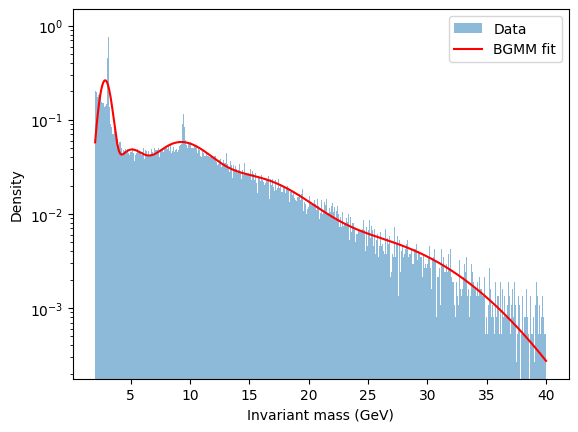

In [38]:
#let us plot the results and compare to the data
from scipy.stats import norm

x = np.linspace(2, 40, 1000)
pdf = np.zeros_like(x)
for i in range(bgmm.n_components):
    if weights[i] > 1e-3:
        mean = means[i]
        sigma = sigmas[i]
        weight = weights[i]
        pdf += weight * norm.pdf(x, loc=mean, scale=sigma)
plt.hist(mmaasses, bins=1000, range=(2, 40), density=True, alpha=0.5, label='Data')
plt.plot(x, pdf, label='BGMM fit', color='red')
plt.yscale('log')
plt.xlabel('Invariant mass (GeV)')
plt.ylabel('Density')
plt.legend()
plt.show()


This is just an example. Maybe you can find a way to improve this fitting. The main point would be to first fit a broad background component. 

## Davide's example 

One of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamica assembly of sources in dense environments like globular clusters.


Right now, state-of-the-art analyses seems to say that many channels are all at play. This is a plot by [Zevin et al (2020)](https://arxiv.org/abs/2011.10057)


![Screen%20Shot%202022-01-15%20at%2013.34.38.png](attachment:Screen%20Shot%202022-01-15%20at%2013.34.38.png)

where they consider 5 possibilities for the formation of black hole binaries: common envelop (CE), chemically omogenous stars (CHE), globular clusters (GC), nuclear star clusters (NSC) and stable mass transfer (SMT). 

If you want to know more about LIGO-driven astrophysics and black hole binaries formation channels, these are some recent reviews: [Mandel and Farmer (2021)](https://arxiv.org/abs/1806.05820), [Mapelli (2021)](https://arxiv.org/abs/2106.00699), [Gerosa and Fishbach (2021)](https://arxiv.org/abs/2105.03439).

Anyway. LIGO measures the masses of many black holes. You can find the dataset at `solutions/formationchannels.npy`.

*Hint*: Note that the data provided are of shape (N,1), not (N,). This might be confusing at first, but it's the format that sklearn wants (more on this in a future lecture).  A useful tool to convert between the two is [np.newaxis](https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it).


In [ ]:
x=np.linspace(0, 5, 6)
print(x, x.shape)
print(x[np.newaxis,:], x[np.newaxis,:].shape)
print(x[:,np.newaxis], x[:,np.newaxis].shape)

Some events form in different astrophysical environments than others. **You want to figure out how many of formation channels are at play.**


The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j) $

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability.

#### Tasks

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

2) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. This is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in scientific research!

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in detail.

4) For each of this fits, compute the AIC (easy! It's a attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

6) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`: you'll need them both. Try to understand what they do and how you can put them together.




[Davide's solution](https://github.com/dgerosa/astrostatistics_bicocca_2022/blob/main/solutions/S11_formationchannels.ipynb) 